In [1]:
# ==============================================================================
# ÉTAPE 1 : IMPORTATION ET CONFIGURATION DE L'ENVIRONNEMENT
# ==============================================================================

# --- Gestion du Système et Alertes ---
import os                        # Gérer les chemins, répertoires et fichiers
if os.path.exists("model_lstm_new.h5"):
    os.remove("model_lstm_new.h5")
if os.path.exists("tokenizer_keras.pickle"):
    os.remove("tokenizer_keras.pickle")

import warnings                  # Gestion des messages d'alerte
warnings.filterwarnings('ignore') # Masquer les warnings pour un affichage propre

# --- Manipulation et Analyse de Données ---
import pandas as pd              # Lecture et manipulation des DataFrames
import numpy as np               # Opérations numériques et gestion des tableaux

# --- Visualisation de Données ---
import matplotlib.pyplot as plt  # Création de graphiques de base
import seaborn as sns            # Visualisation statistique avancée (Matrice de confusion)

# Affichage
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports généraux chargés")


✅ Imports généraux chargés


IMPORTATION NLP CLASSIQUE (NLTK + SPACY)

In [2]:
# NLP classique
import re
import spacy
import nltk
from nltk.corpus import stopwords


# Chargement du modèle linguistique SpaCy
nlp = spacy.load("en_core_web_sm")


print("✅ NLP classique prêt")

✅ NLP classique prêt


CHARGEMENT DU CORPUS (BBC NEWS)

In [5]:
import zipfile


def charger_corpus_bbc(chemin_zip, limite_par_cat=150):
    donnees = []
    categories = ['business', 'entertainment', 'tech']
    compteur = {cat: 0 for cat in categories}


    with zipfile.ZipFile(chemin_zip, 'r') as z:
        for info in z.infolist():
            parts = info.filename.split('/')
            if info.filename.endswith('.txt') and len(parts) > 1:
                cat = parts[-2]
                if cat in categories and compteur[cat] < limite_par_cat:
                    with z.open(info.filename) as f:
                        texte = f.read().decode('latin-1')
                        donnees.append({
                            'Thématique': cat,
                            'Texte_Brut': texte
                        })
                        compteur[cat] += 1
            if all(compteur[c] >= limite_par_cat for c in categories):
                break


    df = pd.DataFrame(donnees)
    print("\nDistribution des classes :")
    print(df['Thématique'].value_counts())
    return df


df_bbc = charger_corpus_bbc('bbc-fulltext.zip')
df_bbc.head()



Distribution des classes :
Thématique
business         150
entertainment    150
tech             150
Name: count, dtype: int64


,Thématique,Texte_Brut
0,business,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,High fuel prices hit BA's profits\n\nBritish A...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...


In [6]:
# ⚠️ IMPORTANT : ce texte nettoyé est utilisé pour LSTM / Word2Vec
# ⚠️ Le texte BRUT sera utilisé pour BERT / DistilBERT


def pipeline_nlp(texte):
    texte = re.sub(r'https?://\S+|www\.\S+', '', texte)
    texte = re.sub(r'<.*?>', '', texte)
    texte = re.sub(r'[^a-zA-Z\s]', ' ', texte)
    texte = re.sub(r'\s+', ' ', texte).strip()

    doc = nlp(texte)

    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]

    analyse = [
        {'mot': t.text, 'pos': t.pos_, 'dep': t.dep_}
        for t in doc if not t.is_space
    ]

    return " ".join(tokens), analyse

df_bbc['Texte_Nettoye'], df_bbc['Analyse_Syntaxique'] = zip(*df_bbc['Texte_Brut'].apply(pipeline_nlp))
df_bbc.head()


,Thématique,Texte_Brut,Texte_Nettoye,Analyse_Syntaxique
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...,"[{'mot': 'Ad', 'pos': 'NOUN', 'dep': 'compound..."
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit high l...,"[{'mot': 'Dollar', 'pos': 'NOUN', 'dep': 'comp..."
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...,"[{'mot': 'Yukos', 'pos': 'PROPN', 'dep': 'comp..."
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba s profit british airway...,"[{'mot': 'High', 'pos': 'ADJ', 'dep': 'amod'},..."
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq shares uk dri...,"[{'mot': 'Pernod', 'pos': 'NOUN', 'dep': 'comp..."


WORD2VEC & EMBEDDINGS DE DOCUMENTS

In [13]:

from gensim.models import Word2Vec

sentences = [txt.split() for txt in df_bbc['Texte_Nettoye']]

model_w2v = Word2Vec(
sentences,
vector_size=100,
window=5,
min_count=2,
workers=4
)

print("Taille vocabulaire Word2Vec :", len(model_w2v.wv))

# Vecteur de document = moyenne des vecteurs de mots
def document_vector(tokens, model):
    mots = [w for w in tokens if w in model.wv]
    if not mots:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[mots], axis=0)

df_bbc['Doc_Vector'] = df_bbc['Texte_Nettoye'].apply(lambda x: document_vector(x.split(), model_w2v))


Taille vocabulaire Word2Vec : 6118


VISUALISATION PCA

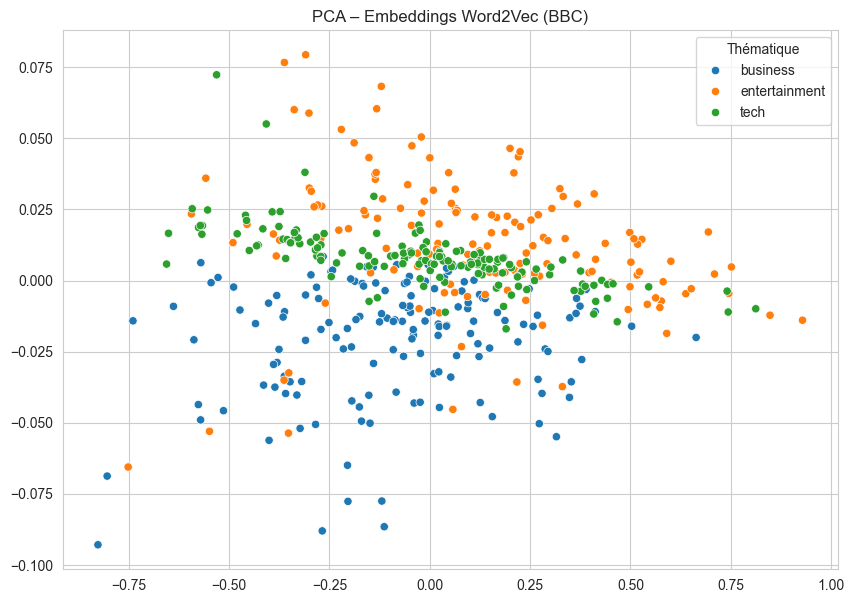

In [14]:
from sklearn.decomposition import PCA
X_vec = np.stack(df_bbc['Doc_Vector'].values)
y_cat = df_bbc['Thématique']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_cat)
plt.title("PCA – Embeddings Word2Vec (BBC)")
plt.show()


PRÉPARATION DES DONNÉES (LSTM)

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Encodage des labels
le = LabelEncoder()
df_bbc['target'] = le.fit_transform(df_bbc['Thématique'])

y = to_categorical(df_bbc['target'])
num_classes = y.shape[1]

# Séquences de mots
max_words = 5000
max_len = 200

tokenizer_keras = Tokenizer(num_words=max_words)
tokenizer_keras.fit_on_texts(df_bbc['Texte_Nettoye'])

sequences = tokenizer_keras.texts_to_sequences(df_bbc['Texte_Nettoye'])
X_seq = pad_sequences(sequences, maxlen=max_len)


MODÈLE LSTM BIDIRECTIONNEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

embedding_dim = 100
word_index = tokenizer_keras.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words and word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]


model_lstm = Sequential([
    Embedding(input_dim=max_words,
              output_dim=100,
              weights=[embedding_matrix],
              input_shape=(max_len,),  # <- important
              trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,707 (2.25 MB)

 Trainable params: 88,707 (346.51 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [18]:
from sklearn.model_selection import train_test_split


X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y, test_size=0.2, random_state=42
)


history = model_lstm.fit(X_train_lstm, y_train_lstm,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_lstm, y_test_lstm))



Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.3917 - loss: 1.0891 - val_accuracy: 0.4111 - val_loss: 1.0383
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4750 - loss: 1.0444 - val_accuracy: 0.4222 - val_loss: 1.0380
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4861 - loss: 1.0228 - val_accuracy: 0.4222 - val_loss: 1.0558
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4972 - loss: 1.0251 - val_accuracy: 0.4333 - val_loss: 1.0408
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.5028 - loss: 1.0137 - val_accuracy: 0.4444 - val_loss: 1.0117
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.4806 - loss: 1.0044 - val_accuracy: 0.4333 - val_loss: 1.0212
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.4722 - loss: 1.0179 - val_accuracy: 0.4333 - val_loss: 1.0220
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.4861 - loss: 1.0136 - val_accuracy: 0.4556

ÉVALUATION LSTM

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
               precision    recall  f1-score   support

     business       0.00      0.00      0.00        35
entertainment       0.31      0.70      0.43        23
         tech       0.61      0.72      0.66        32

     accuracy                           0.43        90
    macro avg       0.30      0.47      0.36        90
 weighted avg       0.29      0.43      0.34        90



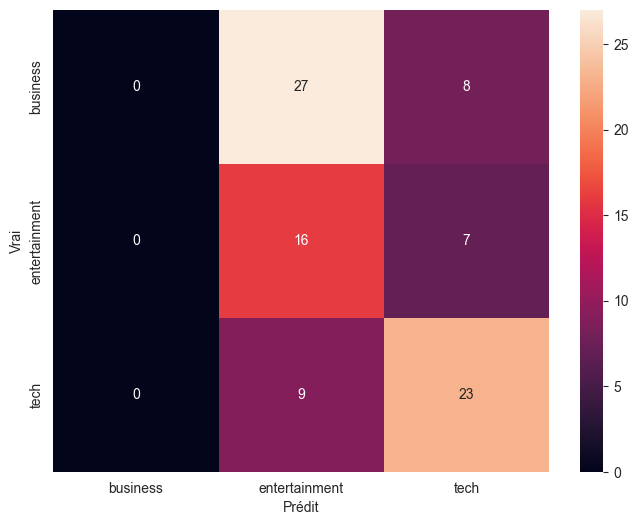

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_lstm.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.show()


SAUVEGARDE LSTM

In [21]:

# Sauvegarde correcte pour TF 2.13+
# Sauvegarde correcte pour Keras 3 / TensorFlow 2.13+
model_lstm.save("model_lstm.keras")  # format natif Keras 3


import pickle
with open('tokenizer_keras.pickle', 'wb') as f:
    pickle.dump(tokenizer_keras, f)

print("✅ Nouveau modèle LSTM et tokenizer sauvegardés")

✅ Nouveau modèle LSTM et tokenizer sauvegardés



TRANSFORMERS (BERT & DISTILBERT)

In [20]:
!pip install tf_keras

In [30]:
import os


import streamlit as st
import time  # nécessaire si tu utilises st.spinner

# Puis tous les autres imports
import spacy
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification



In [23]:

# Fonction générique de fine-tuning
def train_transformer(model_name, texts, labels):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    y_int = np.argmax(labels, axis=1)

    enc = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )

    model = TFAutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=labels.shape[1],
        from_pt=True
    )

    import tf_keras as keras
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=2e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )


    model.fit(dict(enc), y_int, epochs=3, batch_size=16)
    return model, tokenizer


In [24]:
# Fine-tuning BERT (texte BRUT)
model_bert, tokenizer_bert = train_transformer(
    'bert-base-uncased',
    df_bbc['Texte_Brut'].tolist(),
    y
)

model_bert.save_pretrained('modele_bert')
tokenizer_bert.save_pretrained('modele_bert')

print("✅ BERT entraîné et sauvegardé")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


29/29 [==============================] - 216s 5s/step - loss: 0.7628 - accuracy: 0.7956
Epoch 2/3
29/29 [==============================] - 157s 5s/step - loss: 0.2694 - accuracy: 0.9733
Epoch 3/3
29/29 [==============================] - 156s 5s/step - loss: 0.0912 - accuracy: 0.9956
✅ BERT entraîné et sauvegardé


In [25]:
# Fine-tuning DistilBERT (comparaison)
model_distil, tokenizer_distil = train_transformer(
    'distilbert-base-uncased',
    df_bbc['Texte_Brut'].tolist(),
    y
)

model_distil.save_pretrained('modele_distilbert')
tokenizer_distil.save_pretrained('modele_distilbert')

print("✅ DistilBERT entraîné et sauvegardé")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Epoch 1/3
29/29 [==============================] - 114s 3s/step - loss: 0.9187 - accuracy: 0.7622
Epoch 2/3
29/29 [==============================] - 80s 3s/step - loss: 0.3276 - accuracy: 0.9822
Epoch 3/3
29/29 [==============================] - 76s 3s/step - loss: 0.0970 - accuracy: 0.9933
✅ DistilBERT entraîné et sauvegardé


EXTRACTION D’INFORMATIONS & RÉSUMÉ

In [26]:
from transformers import pipeline

# Extraction d'entités + résumé extractif
def extraire_infos(texte):
    doc = nlp(texte)
    entites = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON','ORG','GPE']]
    phrases = [sent.text for sent in doc.sents]
    resume_ext = ' '.join(phrases[:2])
    return entites, resume_ext

# Résumé abstractif (BART)
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

def resume_abstractif(texte):
    return summarizer(texte[:1024], max_length=130, min_length=30)[0]['summary_text']


Device set to use cpu


In [12]:
!pip install streamlit

   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   -------- ------------------------------- 1.8/9.0 MB 10.1 MB/s eta 0:00:01
   ------------------ --------------------- 4.2/9.0 MB 11.1 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/9.0 MB 8.8 MB/s eta 0:00:01
   --------------------------- ------------ 6.3/9.0 MB 7.7 MB/s eta 0:00:01
   ------------------------------- -------- 7.1/9.0 MB 6.9 MB/s eta 0:00:01
   --------------------------------- ------ 7.6/9.0 MB 6.2 MB/s eta 0:00:01
   -------------------------------------- - 8.7/9.0 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 9.0/9.0 MB 5.8 MB/s  0:00:01
   ---------------------------------------- 0.0/795.4 kB ? eta -:--:--
   ---------------------------------------  786.4/795.4 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 795.4/795.4 kB 3.9 MB/s  0:00:00
   ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
   --- --------------------

In [27]:
#4. Interface Streamlit (Démonstration)
import streamlit as st
import time

st.title("🤖 Assistant Intelligent NLP")

uploaded_file = st.file_uploader("Upload d'un document TXT", type="txt")

if uploaded_file:
    texte = uploaded_file.read().decode("utf-8")
    
    st.subheader("Actions")
    col1, col2, col3 = st.columns(3)
    
    modele_choisi = st.selectbox("Choisir le modèle de classification", ["LSTM", "BERT", "DistilBERT"])

    # --- Classification ---
    if col1.button("🎯 Classifier"):
        start = time.time()

        if modele_choisi == "BERT":
            inputs = tokenizer_bert(texte, return_tensors="tf", truncation=True, padding=True, max_length=128)
            outputs = model_bert(inputs)
            probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
            categories = ["Business", "Entertainment", "Tech"]
            label = categories[np.argmax(probs)]

        elif modele_choisi == "LSTM":
            # Exemple : transformer texte en séquence + pad + prédiction
            # sequences = tokenizer_lstm.texts_to_sequences([texte])
            # X_input = pad_sequences(sequences, maxlen=max_len)
            # probs = model_lstm.predict(X_input)[0]
            # label = categories[np.argmax(probs)]
            st.warning("LSTM pas encore branché")  # À remplacer par ton code LSTM

        st.info(f"✅ Modèle : {modele_choisi}")
        st.write(f"Classe prédite : **{label}**")
        if 'probs' in locals():
            st.write("Probabilités :", {cat: round(float(p), 3) for cat, p in zip(categories, probs)})
        st.caption(f"Temps : {round(time.time()-start, 3)}s")

    # --- Extraction d'entités ---
    if col2.button("🔍 Extraire infos"):
        doc = nlp(texte)
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE"]]
        st.write("**Entités détectées :**", entities)

    # --- Résumé abstractif ---
    if col3.button("📝 Résumer"):
        with st.spinner("Le modèle BART génère le résumé..."):
            summary = summarizer(texte[:1024], max_length=130, min_length=30)[0]['summary_text']
            st.success(summary)

    st.divider()
    st.subheader("Texte Original")
    st.write(texte)
     

2026-01-11 19:17:53.528 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:54.442 
  command:

    streamlit run c:\Users\abiol\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-01-11 19:17:54.445 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:54.456 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:54.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:54.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:54.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-11 19:17:

In [30]:
# Installation de localtunnel
!pip install -g localtunnel


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -g


In [28]:
%%writefile app.py
# ======================
# app.py - Version fonctionnelle
# ======================

import os

import streamlit as st
import time
import numpy as np
import tensorflow as tf
import spacy
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification

# --- Configuration de la page ---
st.set_page_config(page_title="NLP BBC Demo", layout="wide")
st.title("🤖 Analyseur d'Articles BBC News")

# ======================
# --- Chargement des ressources avec cache ---
# ======================
@st.cache_resource
def load_all():
    # SpaCy pour NLP
    nlp = spacy.load("en_core_web_sm")
    
    # Résumé BART
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    
    # BERT
    tokenizer_bert = AutoTokenizer.from_pretrained("modele_bert")
    model_bert = TFAutoModelForSequenceClassification.from_pretrained("modele_bert")
    
    # LSTM + tokenizer Keras
    # Charger le modèle LSTM
    model_lstm = tf.keras.models.load_model("model_lstm.keras", compile=False)

    with open("tokenizer_keras.pickle", "rb") as handle:
        tokenizer_lstm = pickle.load(handle)
    max_len = 200  # longueur utilisée lors de l'entraînement

    return nlp, summarizer, model_bert, tokenizer_bert, model_lstm, tokenizer_lstm, max_len

# Chargement
nlp, summarizer, model_bert, tokenizer_bert, model_lstm, tokenizer_lstm, max_len = load_all()

# ======================
# --- Upload fichier TXT ---
# ======================
uploaded_file = st.file_uploader("Upload d'un fichier TXT", type="txt")
if uploaded_file:
    texte = uploaded_file.read().decode("utf-8")
    
    col1, col2, col3 = st.columns(3)
    modele_choisi = st.selectbox("Choisir le modèle de classification", ["LSTM", "BERT"])

    # --- Bouton CLASSIFIER ---
    if col1.button("🎯 Classifier"):
        start = time.time()
        
        categories = ["Business", "Entertainment", "Tech"]
        
        if modele_choisi == "BERT":
            inputs = tokenizer_bert(texte, return_tensors="tf", truncation=True, padding=True, max_length=128)
            outputs = model_bert(inputs)
            probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
            label = categories[np.argmax(probs)]
        
        elif modele_choisi == "LSTM":
            seq = tokenizer_lstm.texts_to_sequences([texte])
            X_input = pad_sequences(seq, maxlen=max_len)
            probs = model_lstm.predict(X_input)[0]
            label = categories[np.argmax(probs)]

        st.info(f"✅ Modèle utilisé : {modele_choisi}")
        st.write(f"Classe prédite : **{label}**")
        st.write("Probabilités :", {cat: round(float(p), 3) for cat, p in zip(categories, probs)})
        st.caption(f"Temps d'inférence : {round(time.time()-start, 3)}s")

    # --- Bouton EXTRACTION D'ENTITÉS ---
    if col2.button("🔍 Extraire infos"):
        start = time.time()
        doc = nlp(texte)
        entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["PERSON","ORG","GPE"]]
        st.write("**Entités détectées :**", entities)
        st.caption(f"Temps : {round(time.time()-start, 3)}s")

    # --- Bouton RESUMÉ ABSTRACTIF ---
    if col3.button("📝 Résumer"):
        start = time.time()
        with st.spinner("Le modèle BART génère le résumé..."):
            summary = summarizer(texte[:1024], max_length=130, min_length=30)[0]['summary_text']
            st.success(summary)
        st.caption(f"Temps : {round(time.time()-start, 3)}s")

    st.divider()
    st.subheader("Texte Original")
    st.write(texte)


Overwriting app.py


Tester BERT seul (sanity check)

In [29]:
text_test = "Apple releases a new AI-powered chip for business applications."

inputs = tokenizer_bert(
    text_test,
    return_tensors="tf",
    truncation=True,
    padding=True,
    max_length=128
)

outputs = model_bert(inputs)
probas = tf.nn.softmax(outputs.logits, axis=1)

print("Probabilités :", probas.numpy())
print("Classe prédite :", np.argmax(probas))


Probabilités : [[0.0272245  0.01194269 0.96083283]]
Classe prédite : 2


In [134]:
print(le.classes_)
#verifier les classes

['business' 'entertainment' 'tech']


In [135]:
categories = list(le.classes_)
